In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import torchvision

from torch.utils.tensorboard import SummaryWriter

In [17]:
# How to define a pytoch tensor

ndarray = np.array([0, 1, 2])
t1 = torch.from_numpy(ndarray)
t2 = torch.tensor(ndarray)
t_zeros = torch.zeros((2, 3))

print(t1)
print(t2)
print(t_zeros)
print(t2.dtype)
print(t2.device)

tensor([0, 1, 2])
tensor([0, 1, 2])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.int64
cpu


In [5]:
# Check for available devices and select if available
if torch.cuda.is_available():
    device = torch.device("cuda")       #CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")        #Apple GPU
else:
    device = torch.device("cpu")        #if nothing is found use the CPU
print(f"Using device: {device}")

Using device: cuda


In [6]:
#use random seed for reproducability

torch.manual_seed(42)
np.random.seed(42)

In [7]:
#create some data following a sin function with random noise

def true_function(x):
    return np.sin(x)

num_samples = 500
x_data = np.linspace(-2 * np.pi, 2 * np.pi, num_samples)
y_data = true_function(x_data) + np.random.normal(0, 0.1, size=num_samples)

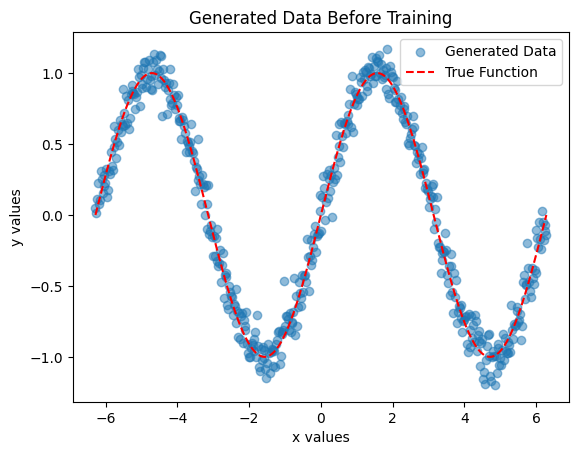

In [8]:
# Plot generated data before training
plt.scatter(x_data, y_data, label="Generated Data", alpha=0.5)
plt.plot(x_data, np.sin(x_data), label="True Function", linestyle="dashed", color='r')
plt.legend()
plt.xlabel('x values')
plt.ylabel('y values')
plt.title("Generated Data Before Training")
plt.show()

In [9]:
# Normalize y_data (mean 0, std 1).   - not really needed for this dataset but a good reminder to do it
y_mean, y_std = y_data.mean(), y_data.std()
y_data = (y_data - y_mean) / y_std

# Convert to PyTorch tensors (specify what device/GPU to define the tensor on)
x_tensor = torch.tensor(x_data, dtype=torch.float32).view(-1, 1).to(device)
y_tensor = torch.tensor(y_data, dtype=torch.float32).view(-1, 1).to(device)

print(y_tensor.shape)

torch.Size([500, 1])


In [10]:
# Split data
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

# Use TensorDataset to create a dataset
train_dataset, val_dataset, test_dataset \
= random_split(TensorDataset(x_tensor, y_tensor), [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Define a custom Dataset class

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    #def load_files:
    #  ...

# Create Dataset
dataset = CustomDataset(x_tensor, y_tensor)

# Split Data
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
#Define neural network as a class
"""
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)
"""

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(1, 32)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(32, 32)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))  # First hidden layer
        hidden = self.relu2(self.layer2(x))  # Second hidden layer (embedding space)
        output = self.layer3(hidden)  # Final regression output
        return output  # Return prediction

In [14]:
#Initialize the model
model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# define writer for tensorboard logging
writer = SummaryWriter("runs/your_model_name")

# log the network architecture
dummy_input = torch.randn(1, 1).to(device)
writer.add_graph(model, dummy_input)

In [18]:
# Train the model
num_epochs = 500
train_losses, val_losses = [], []

for epoch in range(num_epochs): # loop through every epoch
    # Training
    model.train() # The model should be in training mode to use batch normalization and dropout
    train_loss = 0
    for batch_x, batch_y in train_loader: # loop through every batch

        optimizer.zero_grad() # set the gradients to zero
        predictions = model(batch_x) # make a prediction with the current model
        loss = criterion(predictions, batch_y) #calculate the loss based on the prediction
        loss.backward() # calculated the gradiets for the given loss
        optimizer.step() # updates the weights and biases for the given gradients
        train_loss += loss.item() # calulate loss per batch
    train_loss /= len(train_loader) # calulate loss per epoch
    train_losses.append(train_loss)

    writer.add_scalar("train_loss", train_loss, epoch)

    # Validation
    model.eval() # The model should be in eval mode to not use batch normalization and dropout
    val_loss = 0
    with torch.no_grad(): # make sure the gradients are not changed in this step
        for batch_x, batch_y in val_loader:
            predictions = model(batch_x) # make a prediction with the current model
            loss = criterion(predictions, batch_y) # calculate the loss based on the prediction
            val_loss += loss.item() # calulate loss per batch
    val_loss /= len(val_loader) # calulate loss per epoch
    val_losses.append(val_loss)

    writer.add_scalar("val_loss", val_loss, epoch)

    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


      # How to visualize an image in tensorboard
    grid = torchvision.utils.make_grid(torch.randn(16, 3, 32, 32))
    writer.add_image("Random Images", grid, epoch)

    for name, param in model.named_parameters():
        writer.add_histogram(name, param, epoch)#


Epoch 0: Train Loss = 0.5879, Val Loss = 0.3596
Epoch 50: Train Loss = 0.0526, Val Loss = 0.0421
Epoch 100: Train Loss = 0.0367, Val Loss = 0.0380
Epoch 150: Train Loss = 0.0231, Val Loss = 0.0278
Epoch 200: Train Loss = 0.0230, Val Loss = 0.0217
Epoch 250: Train Loss = 0.0278, Val Loss = 0.0302
Epoch 300: Train Loss = 0.0342, Val Loss = 0.0285
Epoch 350: Train Loss = 0.0274, Val Loss = 0.0266
Epoch 400: Train Loss = 0.0259, Val Loss = 0.0310
Epoch 450: Train Loss = 0.0303, Val Loss = 0.0281


In [19]:
# Test the model
model.eval() # The model should be in eval mode to not use batch normalization and dropout
test_loss = 0
with torch.no_grad(): # make sure the gradients are not changed in this step
    for batch_x, batch_y in test_loader:
        predictions = model(batch_x) # make a prediction with the current model
        loss = criterion(predictions, batch_y) # calculate the loss based on the prediction
        test_loss += loss.item() # calulate loss per batch
test_loss /= len(test_loader) # calculate total loss
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Loss: 0.0251


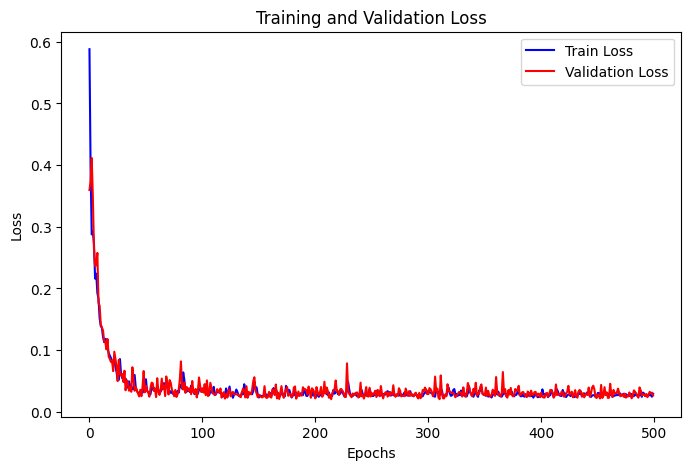

In [20]:
# Plot training/validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


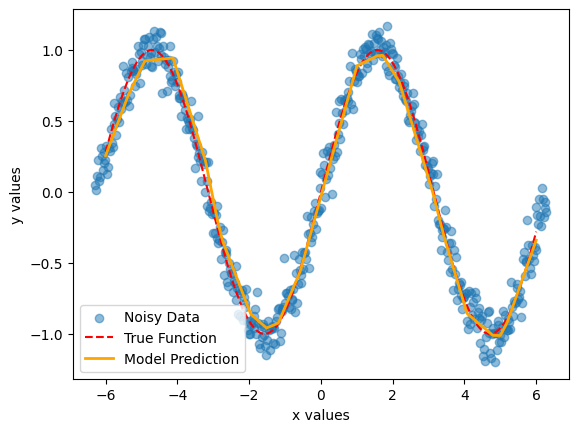

In [27]:
# 6. Final visualization with denormalization
x_grid = np.linspace(-6, 6, 1200).astype(np.float32)
x_grid_tensor = torch.tensor(x_grid).view(-1, 1).to(device)
y_pred_tensor = model(x_grid_tensor).detach().cpu().numpy()
y_pred = y_pred_tensor * y_std + y_mean  # Denormalize predictions

y_true = true_function(x_grid)  # True function

plt.scatter(x_data, y_data * y_std + y_mean, label="Noisy Data", alpha=0.5)
plt.plot(x_grid, y_true, label="True Function", linestyle="dashed", color='r')
plt.plot(x_grid, y_pred, label="Model Prediction", linewidth=2, color = 'orange')
plt.xlabel('x values')
plt.ylabel('y values')
plt.legend()
plt.show()



In [28]:
#close the tensorboard writer
writer.flush()
writer.close()

#display the tensorboard interface
%load_ext tensorboard
%tensorboard --logdir="runs/your_model_name"

Launching TensorBoard...